# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F

from tqdm.notebook import tqdm

# Helper functions

In [93]:
labels_dict = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot",
}

In [2]:
def sample(mean, log_var):
    std = torch.exp(0.5 * log_var)
    eps = torch.randn_like(std, device=mean.device)
    return mean + eps * std

In [3]:
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    return total_params

In [4]:
def plot_losses(reco_losses, kld_losses):
    fig = plt.figure(figsize=(10, 5))

    ax = fig.add_subplot(1, 2, 1)
    ax.plot(reco_losses)
    ax.set_title("Reconstruction Loss")

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(kld_losses)
    ax.set_title("KLD Loss")

In [94]:
def generate_imgs(decoder_nn, cond=False, device=torch.device("cpu")):
    num_img = 32
    new_z = torch.randn(32, 2)
    new_z = new_z.to(device)

    if cond:
        new_labels = torch.randint(0, 10, (num_img,)).to(device)
        new_pred = decoder_nn(new_z, new_labels)
    else:
        new_pred = decoder_nn(new_z)

    new_pred = new_pred.cpu().detach().numpy()

    fig = plt.figure(figsize=(20, 10))
    gs = GridSpec(4, 8)

    for i in range(32):
        ax = fig.add_subplot(gs[i])
        img_array = new_pred[i][0]
        ax.imshow(img_array, cmap="gray")
        ax.axis("off")
        if cond:
            ax.set_title(f"Cond input: {labels_dict[new_labels[i]]}")

In [107]:
def plot_z_dist(train_dl, encoder_nn, cond=False, device=torch.device("cpu")):
    fig = plt.figure(figsize=(14, 6))
    gs = GridSpec(1, 2)

    mus = []
    log_vars = []
    zs = []
    ys = []
    for xb, yb in train_dl:
        xb = xb.to(device)

        if cond:
            mu, log_var = encoder_nn(xb, yb.to(device))
        else:
            mu, log_var = encoder_nn(xb)
        z = sample(mu, log_var)

        mu = mu.cpu().detach().numpy()
        log_var = log_var.cpu().detach().numpy()
        z = z.cpu().detach().numpy()

        mus.extend(mu.tolist())
        log_vars.extend(log_var.tolist())
        zs.extend(z.tolist())
        ys.extend(yb.tolist())

    zs = np.array(zs)
    mus = np.array(mus)
    log_vars = np.array(log_vars)
    ys = np.array(ys)

    ax = fig.add_subplot(gs[0])
    ax.scatter(zs[:, 0], zs[:, 1], c=ys, cmap="tab10", alpha=0.3, s=1)
    colorbar = fig.colorbar(ax.collections[0], ax=ax, label="Labels", ticks=range(10))
    colorbar.solids.set_alpha(1)
    colorbar.ax.set_yticklabels([labels_dict[i] for i in range(10)])
    min_, max_ = np.min(zs), np.max(zs)
    ax.set_xlim(min_, max_)
    ax.set_ylim(min_, max_)
    ax.set_title("Z")
    ax.grid()
    ax.set_aspect("equal")

    gauss0 = np.random.normal(0, 1, len(zs[:, 0]))
    gauss1 = np.random.normal(0, 1, len(zs[:, 0]))
    ax = fig.add_subplot(gs[1])
    ax.scatter(gauss0, gauss1, c="cornflowerblue", alpha=0.3, s=1)
    ax.set_title("Gaus(0,1))")
    ax.set_aspect("equal")
    fig.tight_layout()

    return ys, zs

# Dataset and Dataloader

In [108]:
train_dataset = torchvision.datasets.FashionMNIST(
    root="./data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor(),
)
test_dataset = torchvision.datasets.FashionMNIST(
    root="./data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor(),
)

In [8]:
train_dl = DataLoader(train_dataset, batch_size=500, shuffle=True, num_workers=2)
val_dl = DataLoader(test_dataset, batch_size=5000, shuffle=False, num_workers=2)

<div align="center">
<img src=autoencoder_visualization.svg width=800>
</div>

# AutoEncoder (AE)

### Networks

    - Output needs to be like the input
    - Common trick is to make them symmetric

In [58]:
# Encoder
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.seq1 = nn.Sequential(
            nn.Linear(28 * 28, 300),
            nn.LeakyReLU(),
            nn.Linear(300, 200),
            nn.LeakyReLU(),
            nn.Linear(200, 100),
            nn.LeakyReLU(),
        )

        self.mean_nn = nn.Linear(100, 2)
        self.log_var_nn = nn.Linear(100, 2)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.seq1(x)

        mean = self.mean_nn(x)
        log_var = self.log_var_nn(x)

        return mean, log_var


# Decoder
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.seq1 = nn.Sequential(
            nn.Linear(2, 100),
            nn.LeakyReLU(),
            nn.Linear(100, 200),
            nn.LeakyReLU(),
            nn.Linear(200, 300),
            nn.LeakyReLU(),
            nn.Linear(300, 28 * 28),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.seq1(x)
        x = x.view(-1, 1, 28, 28)

        return x

In [59]:
encoder_nn = Encoder()
decoder_nn = Decoder()

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
encoder_nn = encoder_nn.to(device)
decoder_nn = decoder_nn.to(device)

In [60]:
print(f"Encoder has {count_parameters(encoder_nn):,} trainable parameters")
print(f"Decoder has {count_parameters(decoder_nn):,} trainable parameters")

Encoder has 316,204 trainable parameters
Decoder has 316,784 trainable parameters


In [61]:
optimizer = torch.optim.Adam(
    list(encoder_nn.parameters()) + list(decoder_nn.parameters()), lr=0.001
)

In [ ]:
reco_losses = []
kld_losses = []

for ep in tqdm(range(30)):
    for xb, yb in train_dl:
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad()

        mu, log_var = encoder_nn(xb)
        z = sample(mu, log_var)

        pred = decoder_nn(z)

        # loss
        reco_loss = BCE = F.binary_cross_entropy(pred, xb, reduction="sum")
        kld_loss = -0.5 * torch.sum(1 + log_var - mu**2 - log_var.exp())

        # Not using KLD loss!
        loss = reco_loss + 0 * kld_loss

        loss.backward()
        optimizer.step()

        reco_losses.append(reco_loss.item())
        kld_losses.append(kld_loss.item())

  0%|          | 0/30 [00:00<?, ?it/s]

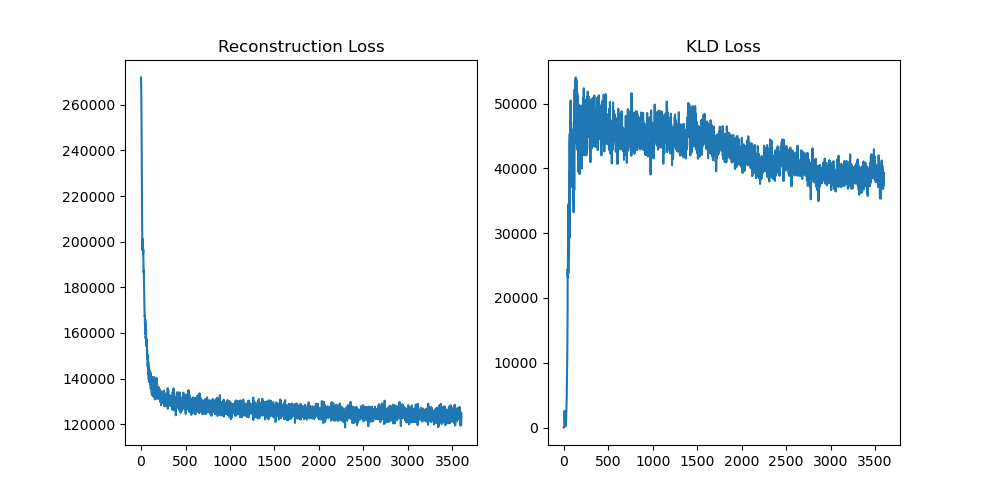

In [63]:
plot_losses(reco_losses, kld_losses)

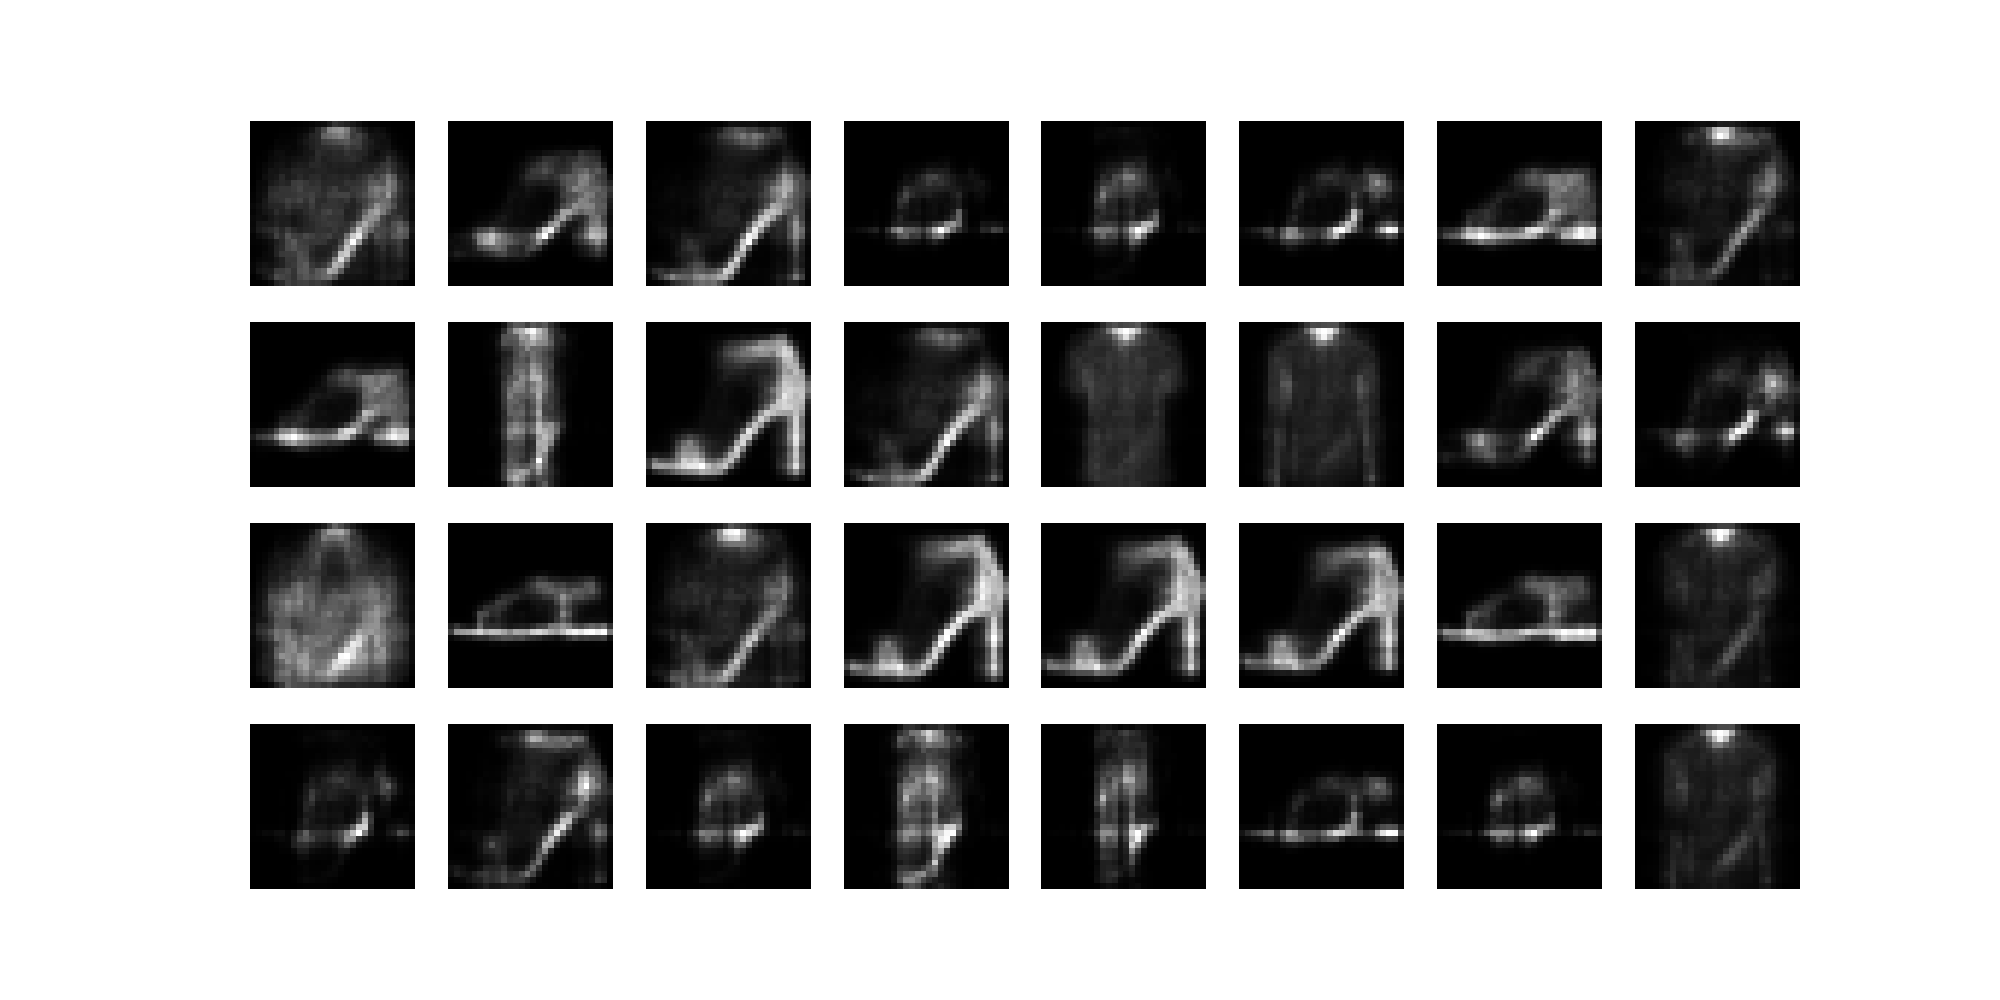

In [64]:
generate_imgs(decoder_nn, device=device)

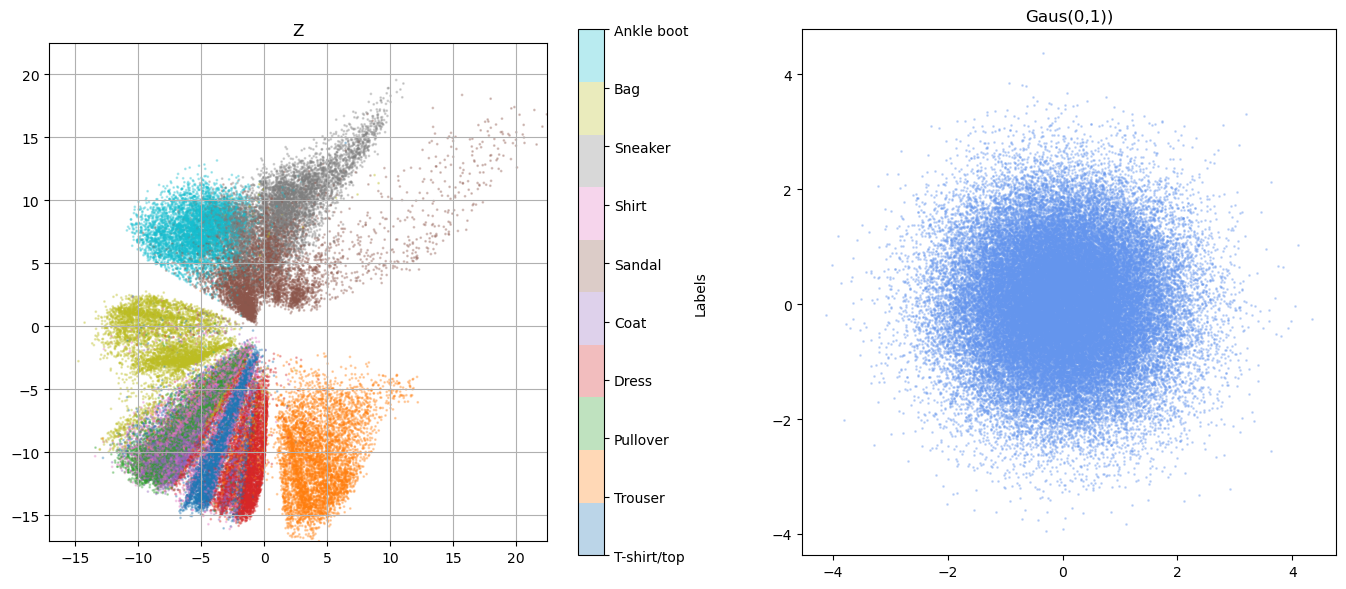

In [98]:
ys, zs = plot_z_dist(train_dl=train_dl, encoder_nn=encoder_nn, device=device)

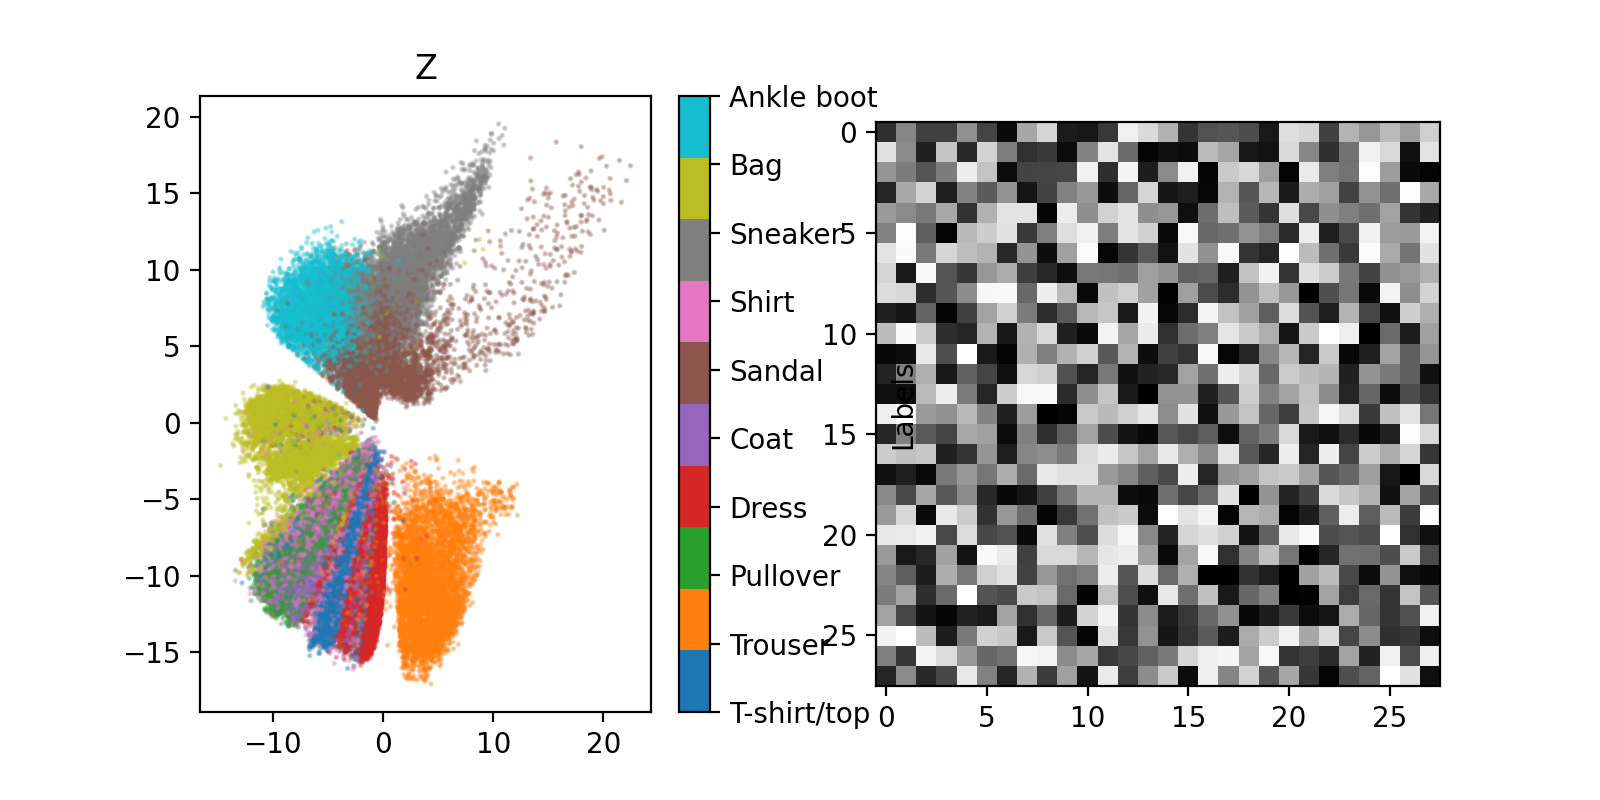

In [106]:
%matplotlib widget

# Uncomment the following lines if you are using Google Colab
# from google.colab import output
# output.enable_custom_widget_manager()

import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets

# Create the figure and subplots
fig = plt.figure(figsize=(8, 4), dpi=200)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# Plot data in the first subplot
ax1.scatter(zs[:, 0], zs[:, 1], c=ys, cmap="tab10", alpha=0.3, s=1)
ax1.set_title("Z")
colorbar = fig.colorbar(ax1.collections[0], ax=ax1, label="Labels", ticks=range(10))
colorbar.solids.set_alpha(1)
colorbar.ax.set_yticklabels([labels_dict[i] for i in range(10)])


# Plot data in the second subplot
x2 = []
y2 = []
points = ax2.imshow(np.random.rand(28, 28), cmap="gray")


# Define the click event handler function
def onclick(event):
    if event.inaxes == ax1:
        x, y = event.xdata, event.ydata
        new_z = torch.tensor([[x, y]], dtype=torch.float32)
        if torch.cuda.is_available():
            new_z = new_z.cuda()
        new_pred = decoder_nn(new_z)
        new_pred = new_pred.cpu().detach().numpy()[0][0]

        points.set_data(new_pred)
        ax2.relim()
        ax2.autoscale_view()
        ax2.set_title(f"x: {x:.1f}, y: {y:.1f}")
        ax2.axis("off")
        fig.canvas.draw()


# Connect the click event handler to the figure
fig.canvas.mpl_connect("button_press_event", onclick)

# Display the plot
plt.show()

# **Variational** Auto Encoder (VAE)

<div align="center">
<img src=vae-gaussian.png width=800>
</div>

In [67]:
vae_encoder_nn = Encoder()
vae_decoder_nn = Decoder()

vae_encoder_nn.to(device)
vae_decoder_nn.to(device)

Decoder(
  (seq1): Sequential(
    (0): Linear(in_features=2, out_features=100, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=100, out_features=200, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=200, out_features=300, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=300, out_features=784, bias=True)
    (7): Sigmoid()
  )
)

In [68]:
optimizer = torch.optim.Adam(
    list(vae_encoder_nn.parameters()) + list(vae_decoder_nn.parameters()), lr=0.001
)

In [69]:
reco_losses = []
kld_losses = []

for ep in tqdm(range(50)):
    for xb, yb in train_dl:
        xb = xb.to(device)
        optimizer.zero_grad()

        mu, log_var = vae_encoder_nn(xb)
        z = sample(mu, log_var)

        pred = vae_decoder_nn(z)

        # loss
        reco_loss = BCE = F.binary_cross_entropy(pred, xb, reduction="sum")
        kld_loss = -0.5 * torch.sum(1 + log_var - mu**2 - log_var.exp())

        loss = reco_loss + kld_loss

        loss.backward()
        optimizer.step()

        reco_losses.append(reco_loss.item())
        kld_losses.append(kld_loss.item())

  0%|          | 0/50 [00:00<?, ?it/s]

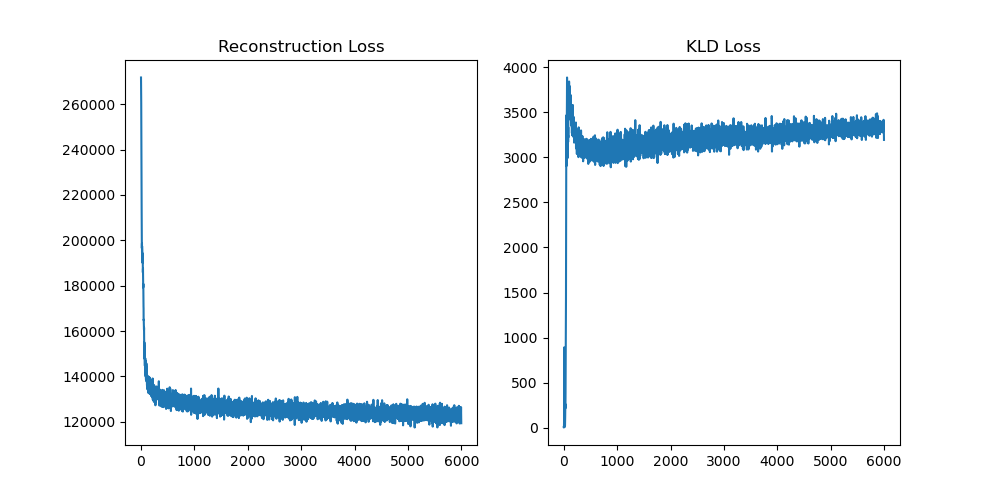

In [70]:
plot_losses(reco_losses, kld_losses)

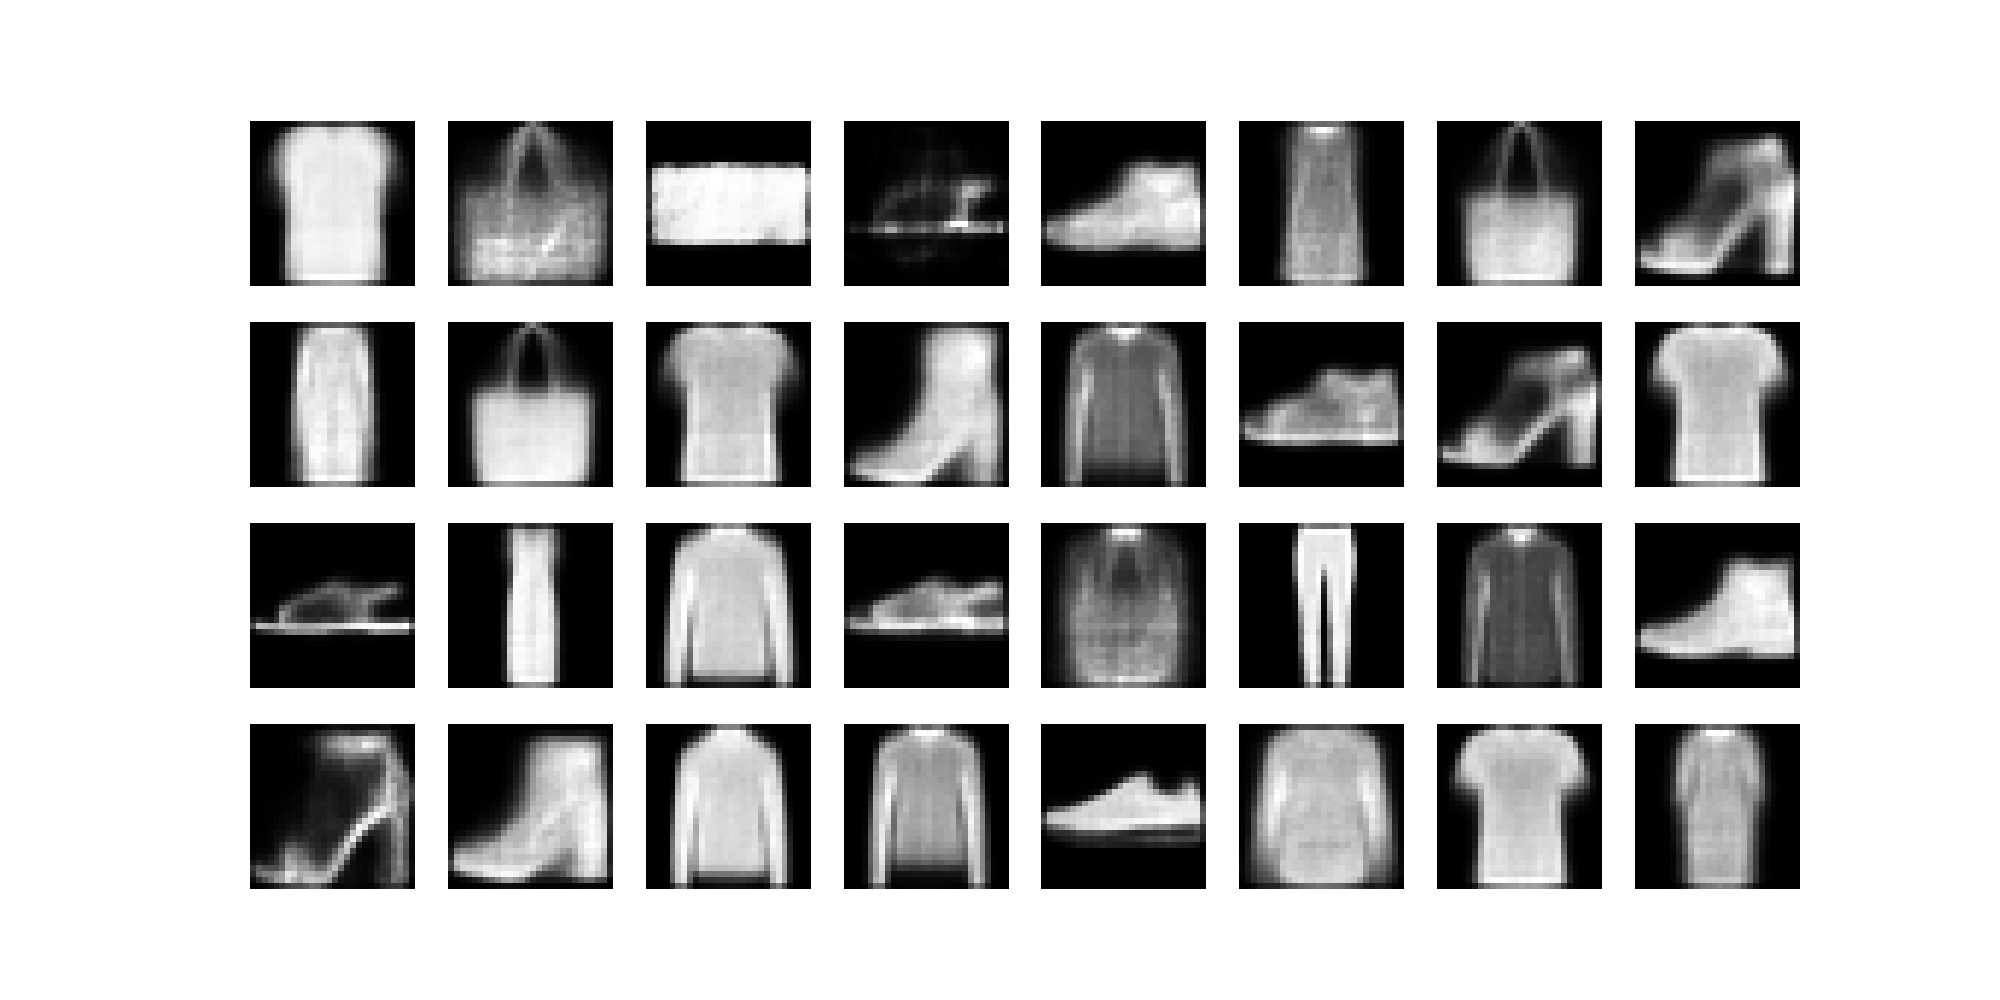

In [71]:
generate_imgs(vae_decoder_nn, cond=False, device=device)

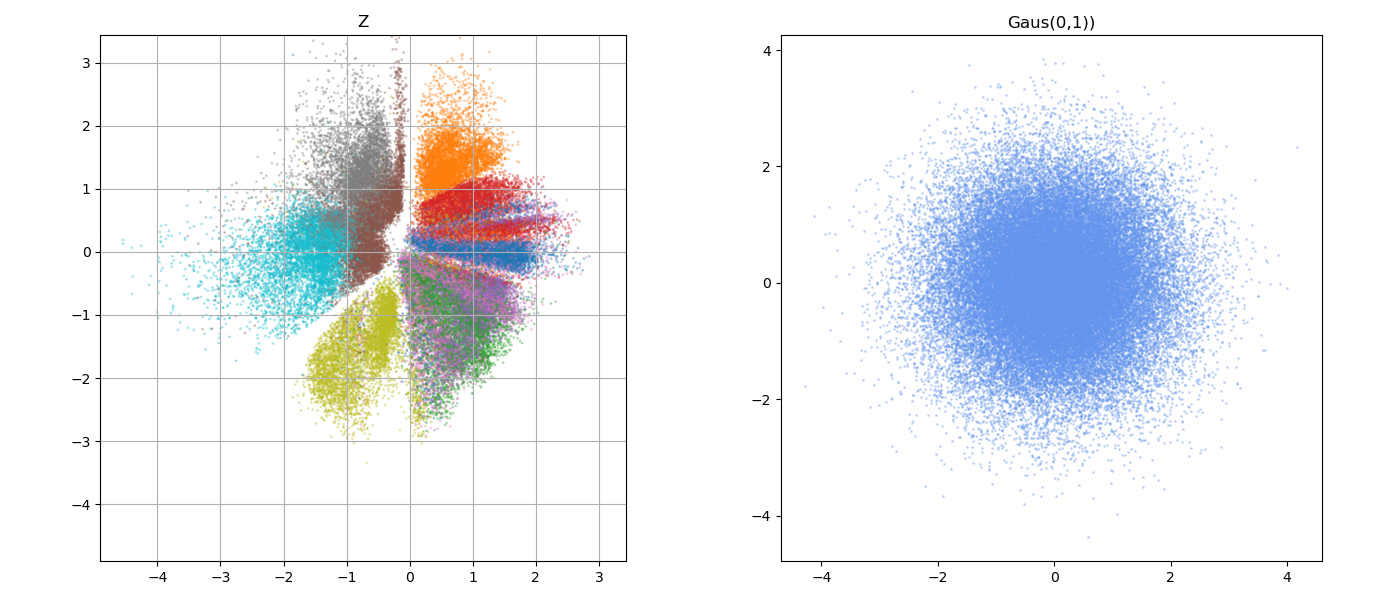

In [72]:
_ = plot_z_dist(train_dl=train_dl, encoder_nn=vae_encoder_nn, device=device)

In [89]:
import scipy

x_dist = np.linspace(0.01, 0.99, 20)
y_dist = np.linspace(0.01, 0.99, 20)
x_dist, y_dist = np.meshgrid(x_dist, y_dist)
x_dist = x_dist.flatten()
y_dist = y_dist.flatten()

x_dist_gauss = scipy.stats.norm.ppf(x_dist, 0, 1)
y_dist_gauss = scipy.stats.norm.ppf(y_dist, 0, 1)

new_z = np.array([x_dist_gauss, y_dist_gauss]).T
new_z = torch.tensor(new_z, dtype=torch.float32)

new_pred = vae_decoder_nn(new_z.to(device)).cpu().detach().numpy()

In [90]:
%matplotlib inline

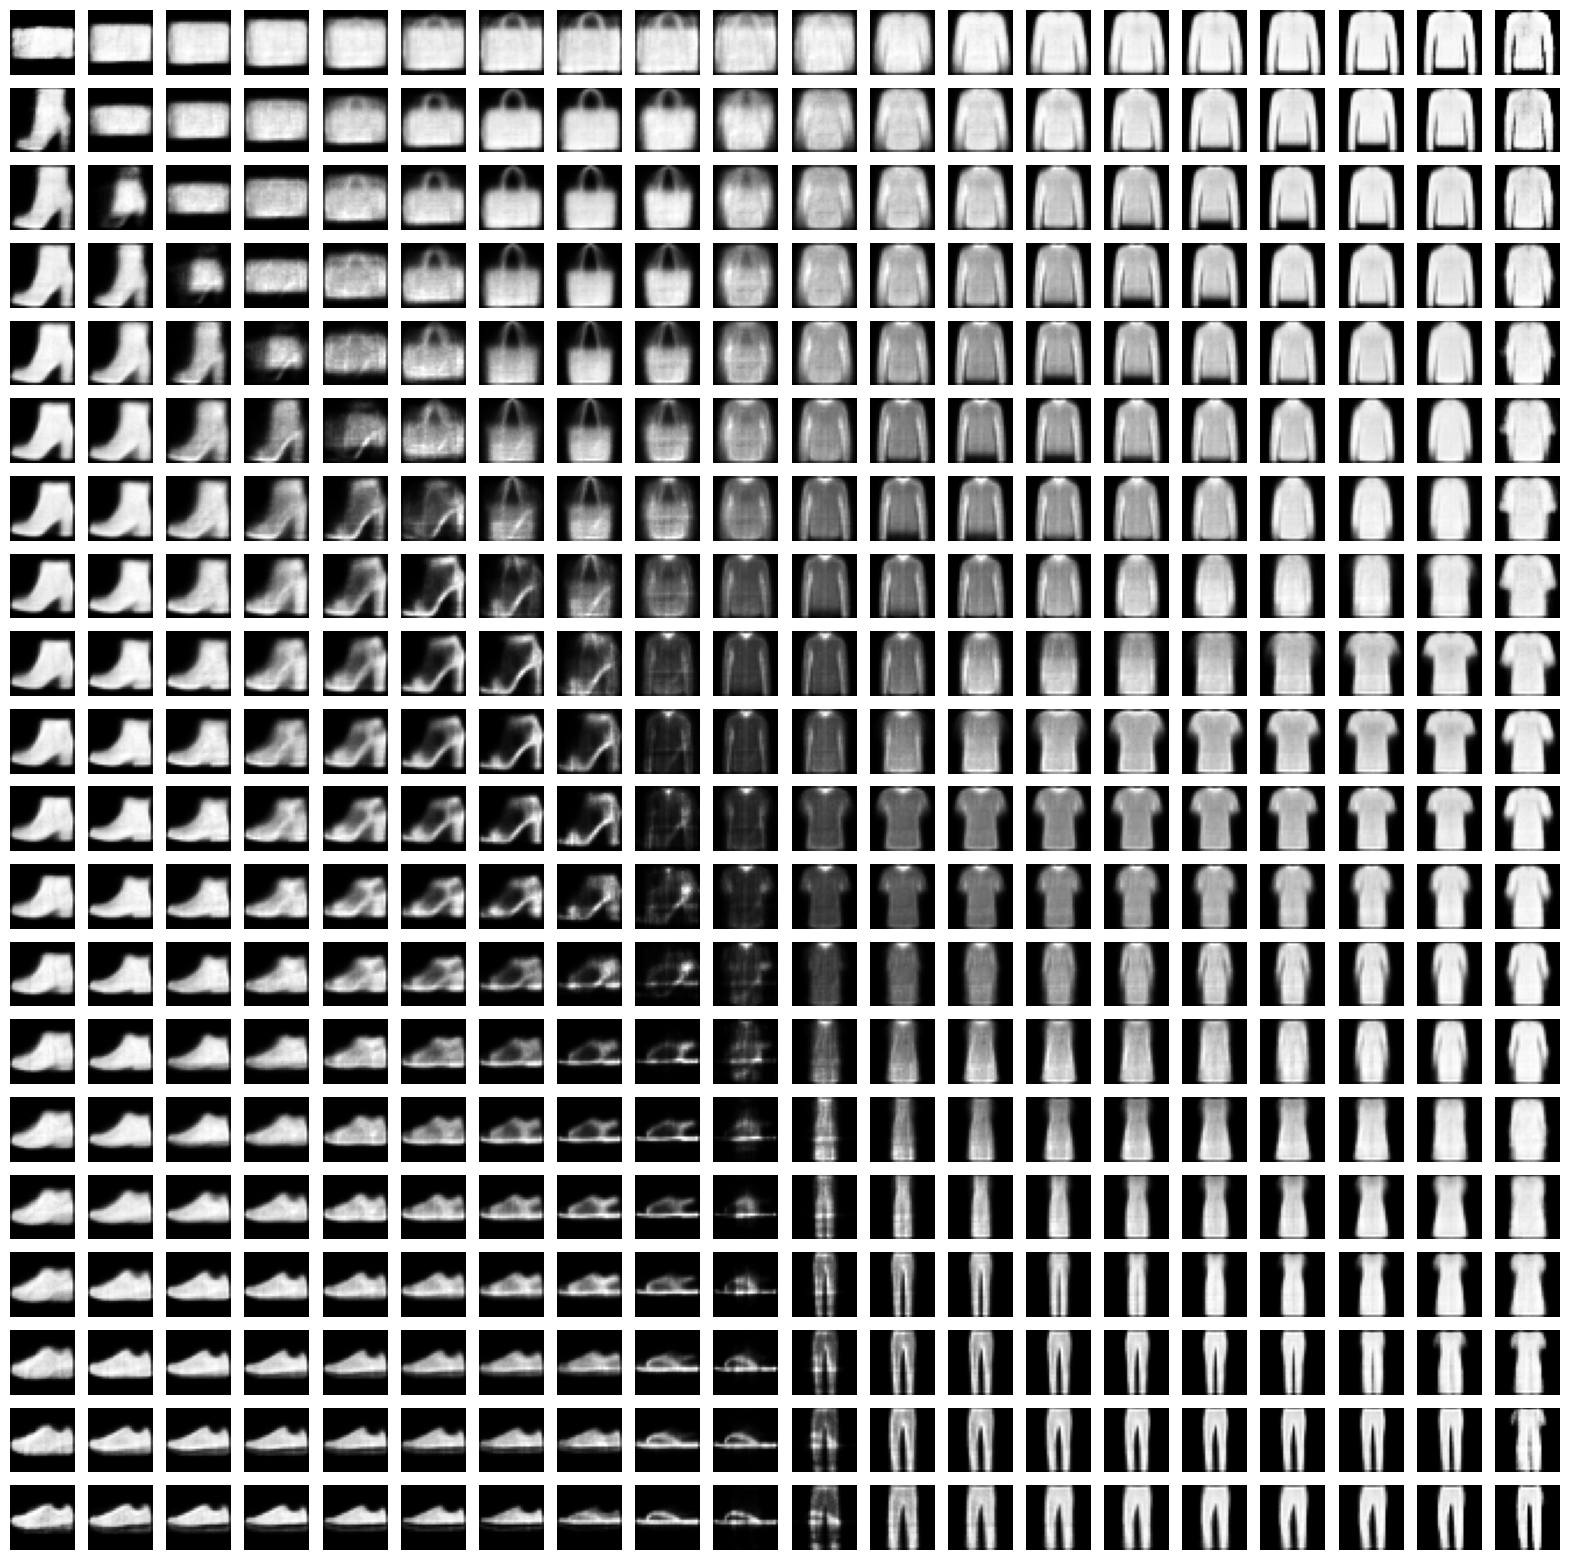

In [92]:
fig = plt.figure(figsize=(20, 20), dpi=100)
gs = GridSpec(20, 20)

for i in range(len(new_pred)):
    ax = fig.add_subplot(gs[i])
    img_array = new_pred[i][0]
    ax.imshow(img_array, cmap="gray")
    ax.axis("off")
plt.show()

# **Conditional** Variational Auto Encoder (cVAE)

### Networks

In [38]:
# Encoder
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.embd = nn.Embedding(10, 10)
        self.seq1 = nn.Sequential(
            nn.Linear(28 * 28 + 10, 300),
            nn.LeakyReLU(),
            nn.Linear(300, 200),
            nn.LeakyReLU(),
            nn.Linear(200, 100),
            nn.LeakyReLU(),
        )

        self.mean_nn = nn.Linear(100, 2)
        self.log_var_nn = nn.Linear(100, 2)

    def forward(self, x, label):
        x = x.view(-1, 28 * 28)
        one_hot_label = self.embd(label)
        x = torch.cat([x, one_hot_label], dim=1)
        x = self.seq1(x)

        mean = self.mean_nn(x)
        log_var = self.log_var_nn(x)

        return mean, log_var


# Decoder
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.embd = nn.Embedding(10, 10)
        self.seq1 = nn.Sequential(
            nn.Linear(2 + 10, 100),
            nn.LeakyReLU(),
            nn.Linear(100, 200),
            nn.LeakyReLU(),
            nn.Linear(200, 300),
            nn.LeakyReLU(),
            nn.Linear(300, 28 * 28),
            nn.Sigmoid(),
        )

    def forward(self, x, label):
        one_hot_label = self.embd(label)
        x = torch.cat([x, one_hot_label], dim=1)
        x = self.seq1(x)
        x = x.view(-1, 1, 28, 28)

        return x

In [40]:
encoder_nn = Encoder()
decoder_nn = Decoder()

encoder_nn.to(device)
decoder_nn.to(device)

Decoder(
  (embd): Embedding(10, 10)
  (seq1): Sequential(
    (0): Linear(in_features=12, out_features=100, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=100, out_features=200, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=200, out_features=300, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=300, out_features=784, bias=True)
    (7): Sigmoid()
  )
)

In [41]:
optimizer = torch.optim.Adam(
    list(encoder_nn.parameters()) + list(decoder_nn.parameters()), lr=0.001
)

In [42]:
reco_losses = []
kld_losses = []

for ep in tqdm(range(30)):
    for xb, yb in train_dl:
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad()

        mu, log_var = encoder_nn(xb, yb)
        z = sample(mu, log_var)

        pred = decoder_nn(z, yb)

        # loss
        reco_loss = BCE = F.binary_cross_entropy(pred, xb, reduction="sum")
        kld_loss = -0.5 * torch.sum(1 + log_var - mu**2 - log_var.exp())

        loss = reco_loss + kld_loss

        loss.backward()
        optimizer.step()

        reco_losses.append(reco_loss.item())
        kld_losses.append(kld_loss.item())

  0%|          | 0/30 [00:00<?, ?it/s]

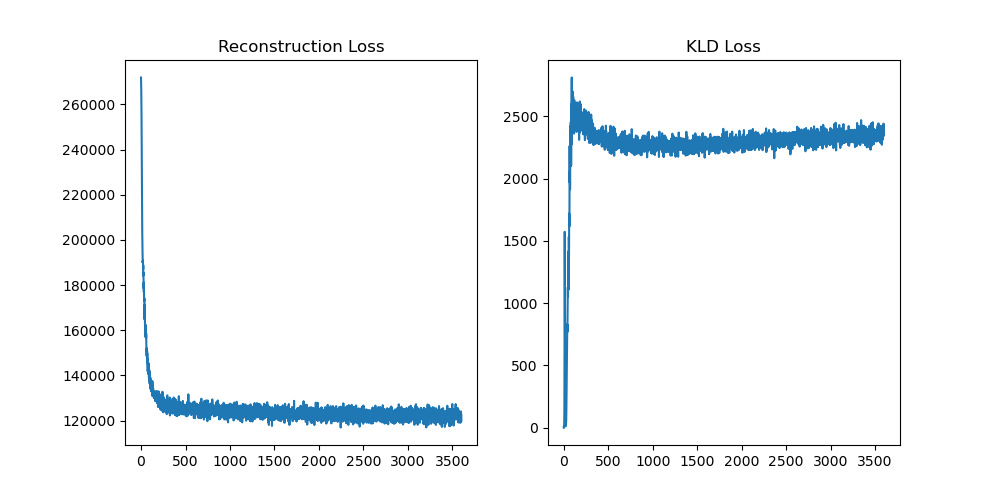

In [43]:
plot_losses(reco_losses, kld_losses)

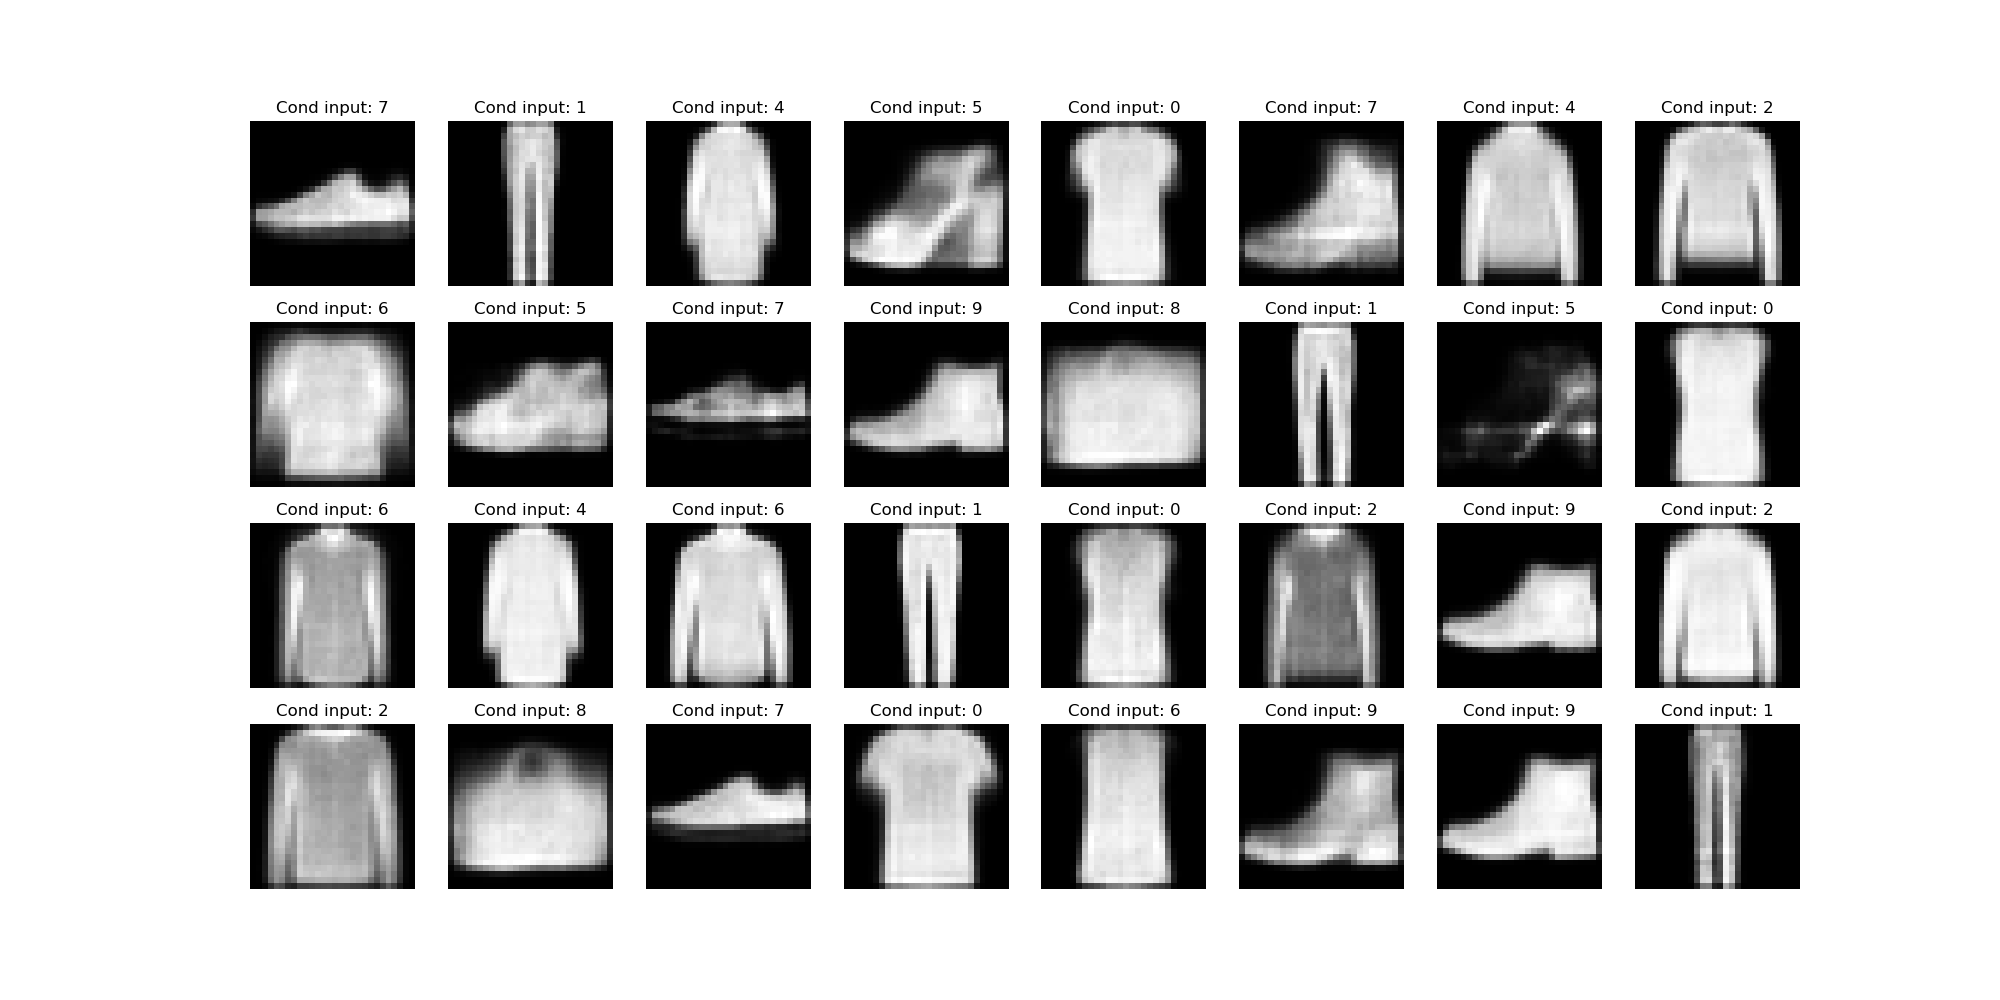

In [49]:
generate_imgs(decoder_nn, cond=True, device=device)

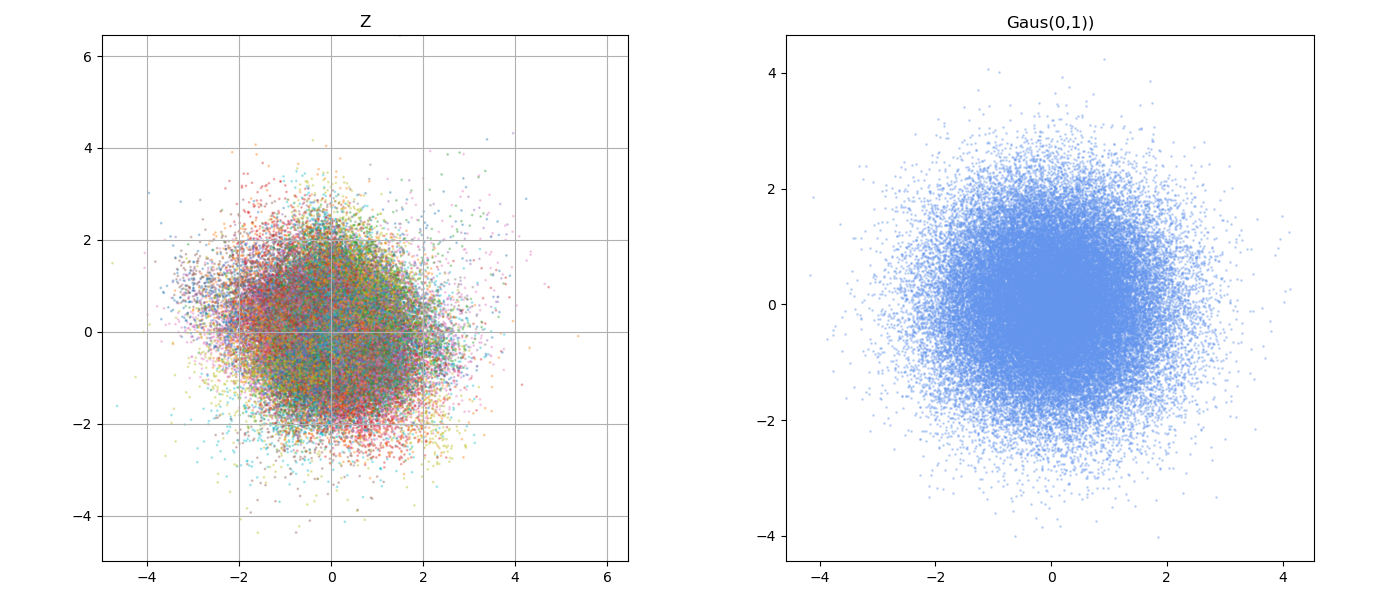

In [50]:
_ = plot_z_dist(train_dl=train_dl, encoder_nn=encoder_nn, cond=True, device=device)